# StreetSmart Algorithm

#### Imports

In [5]:
import pandas as pd
import numpy as np
import osmnx as ox
import glob, os
from datetime import datetime
import googlemaps
import matplotlib.pyplot as plt
import networkx as nx
import sklearn as sk
import heapq
import networkx as nx
import math

gmaps = googlemaps.Client(key="")  

#### Origin/Destination Functions

In [7]:
# Google Maps

## origin = input('Enter your origin: ')
## destination = input('Enter your destination: ')

origin = "Buckingham Palace"
destination = "Trafalgar Square"

org_dict = gmaps.geocode(origin)[0]
org_lat, org_lng = float(org_dict['geometry']['location']['lat']), float(org_dict['geometry']['location']['lng'])
org = (org_lat,org_lng)

des_dict = gmaps.geocode(destination)[0]
des_lat, des_lng = float(des_dict['geometry']['location']['lat']), float(des_dict['geometry']['location']['lng'])
des = (des_lat,des_lng)

In [9]:
# OSMNX variables

graph = ox.graph.graph_from_bbox(org_lat,des_lat,des_lng,org_lng, 
                        network_type="walk",
                        simplify=True,) ##NSEW

org_node = ox.nearest_nodes(graph, org_lng, org_lat)
des_node = ox.nearest_nodes(graph, des_lng, des_lat)

# Databases

nodes, edges = ox.graph_to_gdfs(graph)
nodes, edges = nodes.reset_index(), edges.reset_index()

# Crime Spots dataframe

raw_df = pd.read_csv('data/exports/crime_spots.csv')
df = raw_df.loc[(raw_df['Latitude'] >= nodes['y'].min()) & (raw_df['Latitude'] <= nodes['y'].max())].loc[(raw_df['Longitude'] >= nodes['x'].min()) & (raw_df['Longitude'] <= nodes['x'].max())].sort_values(['Latitude', 'Longitude'], ascending=[True,True]).reset_index()

ImportError: scikit-learn must be installed to search an unprojected graph

#### Matching algorithm

Finds and delegates the score of the closest points in df to each point in nodes

In [4]:
# Algorithm (Final route)

l3=[]
for i in range(len(nodes)):
    l1=[]
    for j in range(len(df)):
        dist = ox.distance.euclidean_dist_vec(nodes['x'][i], 
                                              nodes['y'][i], 
                                              df['Longitude'][j], 
                                              df['Latitude'][j]) * 100000
        l1.append(dist)
    iminimum = l1.index(min(l1))
    l3.append(iminimum)## list of indexes of each minimum value
l4 = []
l5 = []
for i in range(len(l3)):
    score = df['Crime score'][l3[i]]
    count = df['Count'][l3[i]]
    l4.append(score)
    l5.append(count)
nodes['score'] = l4
nodes['count'] = l5

#### Node Class

In [45]:
class Node(object):
    
    ## Special functions
    
    def __init__(self, lat, lng):
        self.id = ox.nearest_nodes(graph, lng, lat)
        self.lat = lat
        self.lng = lng
        self.score = nodes.loc[nodes['osmid']==self.id].reset_index()['score'][0]
        self.children = []
        self.cost = 0
        self.parent = None
    
    def __eq__(self, other): 
        return self.id == other.id
    
    def __lt__(self, other):
        return self.score < other.score
    
    def __str__(self):
        return f'(Node {self.id} at {self.lat},{self.lng} with score {self.score})'
    
    def __repr__(self):
        return f'Node ({self.lat},{self.lng})'
    
    ## Class functions
    
    def find_children(self):
        j = edges.loc[edges['u']==self.id].reset_index()['v']
        for i in range(len(j)):
            child = j[i]
            clat = nodes.loc[nodes['osmid']==child].reset_index()['y'][0]
            clng = nodes.loc[nodes['osmid']==child].reset_index()['x'][0]
            childNode = Node(clat,clng)
            self.children.append(childNode)
            childNode.parent = self
            
    def distance_to(self, other):
        lat1 = math.radians(self.lat)
        lon1 = math.radians(self.lng)
        lat2 = math.radians(other.lat)
        lon2 = math.radians(other.lng)

        # Compute the Haversine distance.
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = (math.sin(dlat/2)**2) + math.cos(lat1) * math.cos(lat2) * (math.sin(dlon/2)**2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = 6371e3 * c  # 6371e3 is the radius of the Earth in meters.

        return distance

#### Best First Search

In [8]:
from queue import PriorityQueue

def best_first_search(start, goal):
    # Create a priority queue to store the nodes that have been visited,
    # but not yet expanded
    frontier = PriorityQueue()
    
    # Create a list to store the nodes that have been visited
    visited = []
    
    # Add the start node to the frontier
    frontier.put(start)
    
    # Keep expanding nodes until the frontier is empty
    while not frontier.empty():
        # Get the node with the highest priority (lowest score) from the frontier
        current = frontier.get()
        
        # Check if we have reached the goal
        if current == goal:
            return path(current)
        
        # Find the children of the current node
        current.find_children()
        
        # Add the children of the current node to the frontier
        for child in current.children:
            if child not in visited:
                visited.append(child)
                child.parent = current
                frontier.put(child)
                
    # If the frontier is empty, return an empty path
    return []

    
def path(node):
    # Recursively trace the path from the goal node back to the start node
    if node.parent is None:
        return [node]
    else:
        return path(node.parent) + [node]

def node_to_osmid(listofnodes):
    osmid = []
    for i in range(len(listofnodes)):
        osmid.append(ox.nearest_nodes(graph, listofnodes[i].lng, listofnodes[i].lat))
    return osmid
    
org = Node(org_lat, org_lng)
des = Node(des_lat, des_lng)
path = best_first_search(org, des)

#### Multi Heuristic A* 

In [66]:
def calculate_cost(current_node, destination_node, score_weight=2):
    
    distance_cost = current_node.distance_to(destination_node)
    score_cost = current_node.score * score_weight
    return distance_cost + score_cost

def mha(start_node, end_node, score_weight=2):
    # Initialize the open and closed lists
    open_list = [(0, start_node)]
    closed_list = []

    # Loop until the open list is empty
    while open_list:
        # Sort the open list by cost
        open_list.sort(key=lambda x: x[0])

        # Get the node with the lowest cost
        current_cost, current_node = open_list.pop(0)

        # Add the current node to the closed list
        closed_list.append(current_node)

        # Check if we have reached the destination
        if current_node == end_node:
            # Return the path from the start to the end
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = current_node.parent
            return path[::-1]

        # Find the children of the current node
        current_node.find_children()

        # Iterate over the children of the current node
        for neighbor in current_node.children:
            # Skip the neighbor if it is already in the closed list
            if neighbor in closed_list:
                continue

            # Calculate the cost to move from the current node to the neighbor
            cost = calculate_cost(current_node, neighbor, score_weight=score_weight)

            # Check if the neighbor is already in the open list
            in_open_list = False
            for i, n in enumerate(open_list):
                if n[1] == neighbor:
                    in_open_list = True
                    # Update the cost if it is lower than the current cost
                    if n[0] > cost:
                        open_list[i] = (cost, neighbor)
                    break

            # Add the neighbor to the open list if it is not already there
            if not in_open_list:
                open_list.append((cost, neighbor))
        
path_astar = mha(org,des)

In [67]:
astar_path = node_to_osmid(path_astar)

#### Tests

In [35]:
shortest_path = nx.shortest_path(graph,org_node,des_node)
safest_path = node_to_osmid(path)

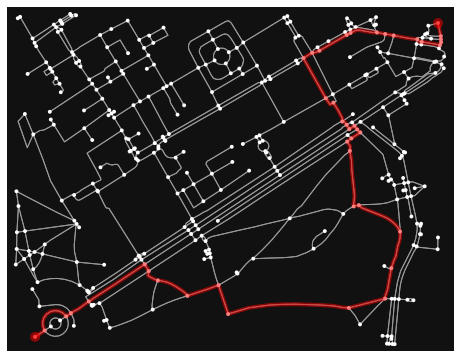

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [43]:
ox.plot.plot_graph_route(graph,safest_path)

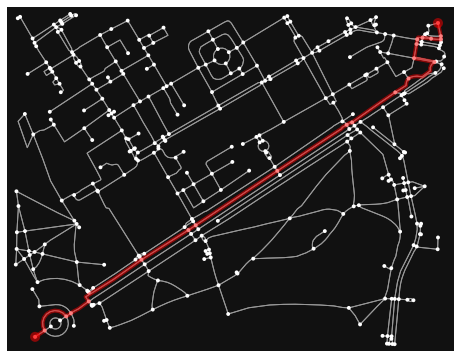

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [42]:
ox.plot.plot_graph_route(graph,shortest_path)

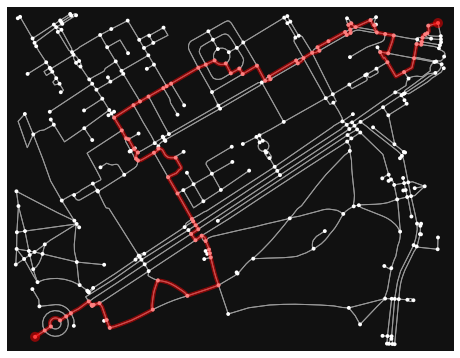

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [68]:
ox.plot.plot_graph_route(graph,astar_path)